# Exercise 2 - databases, molecular modelling
The goal of this exercise is to:
* extract data from different databases (e.g. uniprot, chembl)
* calculate simple properties from protein structure

partially based on <br>
https://github.com/volkamerlab/TeachOpenCADD <br>
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x

## Protein properties

In [1]:
#import and launching of pymol
import pymol
pymol.finish_launching(['pymol', '-qci'])
#pymol.finish_launching(['pymol', '-c'])
from pymol import cmd


In [2]:
pymol.cmd.fetch('3pyy', type = 'pdb') # get one of the pdb files (ABL1 tyrosine kinase)

'3pyy'

In [3]:
pymol.cmd.get_area('3pyy and chain A') # calculate SASA

27643.7578125

In [4]:
##from https://pymolwiki.org/index.php/Center_of_mass
def get_com(selection, state=1, mass=None, quiet=1):
    """
 DESCRIPTION

    Calculates the center of mass

    Author: Sean Law
    Michigan State University
    slaw (at) msu . edu
    """
    quiet = int(quiet)

    totmass = 0.0
    if mass != None and not quiet:
        print("Calculating mass-weighted COM")

    state = int(state)
    model = cmd.get_model(selection, state)
    x, y, z = 0, 0, 0
    for a in model.atom:
        if (mass != None):
            m = a.get_mass()
            x += a.coord[0] * m
            y += a.coord[1] * m
            z += a.coord[2] * m
            totmass += m
        else:
            x += a.coord[0]
            y += a.coord[1]
            z += a.coord[2]

    if (mass != None):
        return x / totmass, y / totmass, z / totmass
    else:
        return x / len(model.atom), y / len(model.atom), z / len(model.atom)

cmd.extend("get_com", get_com)


<function __main__.get_com(selection, state=1, mass=None, quiet=1)>

In [5]:
# if cmd.extend("get_com", get_com) command didn't work, one can add the function like this
cmd.get_com = get_com

In [6]:
cmd.get_com('chain A') # center of mass of chain A

(17.427212702787735, -3.3854455429226746, -20.09767323837569)

In [7]:
# let’s import a few more structure of ABL1
pdb_ids = ['3pyy', '5mo4', '6hd4']
for pdb_id in pdb_ids:
    cmd.fetch(pdb_id, type = 'pdb')

In [8]:
# alignment = translate + rotate to minimize RMSD
print(cmd.align('5mo4 and chain A', '3pyy and chain A'))

(0.49217256903648376, 1532, 5, 1.659255027770996, 1966, 1286.0, 247)


This returns a list with 7 items:

* RMSD after refinement
* Number of aligned atoms after refinement
* Number of refinement cycles
* RMSD before refinement
* Number of aligned atoms before refinement
* Raw alignment score
* Number of residues aligned

In [9]:
# calculate all pairwise RMSDs
rmsd_linear = []
from itertools import combinations
for pdb_pair in combinations(pdb_ids,2):
    print(pdb_pair)
    result = cmd.align(pdb_pair[0] + ' and chain A', pdb_pair[1] + ' and chain A')
    print(result)
    rmsd_linear.append(result[0])#rmsd is the fist number

('3pyy', '5mo4')
(0.492172509431839, 1532, 5, 1.659255027770996, 1966, 1286.0, 247)
('3pyy', '6hd4')
(0.3147238492965698, 1581, 5, 1.353930115699768, 2132, 1403.0, 265)
('5mo4', '6hd4')
(0.47931352257728577, 1658, 5, 2.148344039916992, 2085, 1355.5, 262)


In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage, single, complete, average

In [12]:
# make a 3x3 distance matrix
import numpy as np
rmsd_matrix = np.zeros((3,3))
c = 0
for i in range(2):
    for j in range(i+1,3):
        rmsd_matrix[i][j] = rmsd_linear[c]
        rmsd_matrix[j][i] = rmsd_linear[c]
        c+=1

rmsd_matrix # nicer representation of distances between each of the structures

array([[0.        , 0.49217251, 0.31472385],
       [0.49217251, 0.        , 0.47931352],
       [0.31472385, 0.47931352, 0.        ]])

In [13]:
# perform clustering using average linkage
z = average(rmsd_linear) # scipy.cluster functions take the set of distances in a linear form
print(z) 
# z contains information about N-1 steps in of clustering
# for each step (iteration), fist 2 number represent 2 clusters that were merged,
# third number is the distance between them
# and the last is number of structures in the newly formed cluster

[[0.         2.         0.31472385 2.        ]
 [1.         3.         0.48574302 3.        ]]


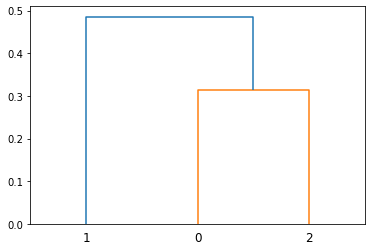

In [16]:
from matplotlib import pyplot as plt
dendrogram(z)
plt.show()

# Exercises & Questions
## Required
Choose one uniprot ID (preferably the same as you did in the first exercise).
* Extract PDB codes related to the protein using uniprot xml format. How does this list compare to the list extracted directly from PDB (Exercise 1)?
* Calculate the SASA (area) of each of these structures and plot a distribution of these values (histogram). Why are they so different? See "Additional tasks" section for hints... Also, there is a small chance that the SASA values would not be so different. Ignore the comment in this case.
* Calculate the distance between all pairs of atoms in one of the structures and find the average distance as well as the maximum distance (also extract which pair of atoms is the most distant). You can use functions from the first exercise, but using pymol functions (e.g. dist) would also work.
* Extract small molecules with available experimental data (IC50 / Kd / Ki, select 2 groups – make sure that the groups are big enough – say at least 50 or 100 compounds) for the protein of interest. Sort them and calculate the mass of 10 most active compounds in each of the groups.

## Additional (at least one of the three)
* For each of the pdb codes, extract for which part (sequence numbers) of the protein the structure is actually solved (from UNIPROT xml format). Select a part of the sequence (e.g. 200-400, or whatever might be reasonable for your protein) and find a subgroup of pdb codes that report structures of this part. In other words, select only pdb structures that provide structures of the same domain (part) of the protein. Are SASAs comparable for this subgroup?
* Calculate pairwise RMSDs for all pairs of structures and cluster them. If you did the first additional exercise, perform clustering on that set. How many clusters did you find?
* Filter out compounds from the set extracted from chembl database (task 4) using Lipinski’s rule of 5. See talktorial 2 from 
https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x).
